# Import

## Frameworks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms, models

import os
# print(os.listdir("../input"))

import shutil 
from tqdm import tqdm
import time
import copy

## Data

In [2]:
!unzip -u "../input/platesv2/plates.zip"

Archive:  ../input/platesv2/plates.zip
   creating: plates/
  inflating: plates/.DS_Store        
   creating: __MACOSX/
   creating: __MACOSX/plates/
  inflating: __MACOSX/plates/._.DS_Store  
   creating: plates/test/
  inflating: plates/test/0071.jpg    
  inflating: plates/test/0717.jpg    
  inflating: plates/test/0703.jpg    
  inflating: plates/test/0065.jpg    
  inflating: plates/test/0059.jpg    
  inflating: plates/test/0515.jpg    
  inflating: plates/test/0273.jpg    
  inflating: plates/test/0267.jpg    
  inflating: plates/test/0501.jpg    
  inflating: plates/test/0529.jpg    
  inflating: plates/test/0298.jpg    
  inflating: plates/test/0461.jpg    
  inflating: plates/test/0307.jpg    
  inflating: plates/test/0313.jpg    
  inflating: plates/test/0475.jpg    
  inflating: plates/test/0449.jpg    
  inflating: plates/test/0105.jpg    
  inflating: plates/test/0663.jpg    
  inflating: plates/test/0677.jpg    
  inflating: plates/test/0111.jpg    
  inflating: plates/

In [3]:
train_dir = 'train'
val_dir = 'val'
class_names = ['cleaned', 'dirty']

# Preprocessing

In [4]:
class DataModule():
    """
    Класс для определения данных в обучающей и тестовой выборках
    """
    
    def init(self):
        self.get_data()
        
    def get_data(self) -> None:
        """
        Разложение данных по директориям - обучающей и валидационной выборкам
        """
        train_dir = 'train'
        val_dir = 'val'
        test_dir = 'test'
        class_names = ['cleaned', 'dirty']
        for dir_name in [train_dir, val_dir]:
            for class_name in class_names:
                os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
        for class_name in class_names:
            source_dir = os.path.join('plates', 'train', class_name)
            for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
                if i % 5 != 0:
                    dest_dir = os.path.join(train_dir, class_name) 
                else:
                    dest_dir = os.path.join(val_dir, class_name)
                shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
                
    def get_dataset(self, type_set='train', transforms=None):
        """
        Получение датасета
        """
        if type_set in ['train', 'val']:
            return torchvision.datasets.ImageFolder(type_set, transforms)
        else:
            print('НЕ ВЕРНЫЙ ПАРАМЕТР type_set')
            
    def get_dataloader(self, type_set='train', transforms=[], bach_size=8):
        """
        Получение даталоадера
        """
        if type_set == 'train':
            if transforms == []:
                dataset = torchvision.datasets.ImageFolder(type_set)
            elif len(transforms) == 1:
                dataset = torchvision.datasets.ImageFolder(type_set, transforms[0])
            else:
                dataset = torchvision.datasets.ImageFolder(type_set, transforms[0])
                for transform in transforms[1:]:
                    dataset += torchvision.datasets.ImageFolder(type_set, transform)
            return torch.utils.data.DataLoader(dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True, 
                                               num_workers=4)
        elif type_set == 'val':
            if transforms == []:
                dataset = torchvision.datasets.ImageFolder(type_set)
            elif len(transforms) == 1:
                dataset = torchvision.datasets.ImageFolder(type_set, transforms[0])
            else:
                dataset = torchvision.datasets.ImageFolder(type_set, transforms[0])
                for transform in transforms[1:]:
                    dataset += torchvision.datasets.ImageFolder(type_set, transform)
            return torch.utils.data.DataLoader(dataset, 
                                               batch_size=batch_size, 
                                               shuffle=False, 
                                               num_workers=4)
        else:
            print("НЕ ВЕРНЫЙ ПАРАМЕТР type_set")

In [5]:
data = DataModule()
data.get_data()

100%|██████████| 21/21 [00:00<00:00, 3018.73it/s]


In [6]:
train_transforms1 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_transforms2 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_transforms3 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomGrayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_transforms4 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_transforms5 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms6 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomGrayscale(),
    transforms.ColorJitter(),
    transforms.RandomRotation(degrees=90, fill=255),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms7 = transforms.Compose([
    transforms.CenterCrop(180),
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
train_transforms = [train_transforms2, train_transforms3, train_transforms1, train_transforms4, train_transforms5, train_transforms6, train_transforms7]

val_transforms = [val_transforms]

In [8]:
batch_size = 8

In [9]:
train_dataloader = data.get_dataloader(type_set='train', transforms=train_transforms, bach_size=batch_size)
val_dataloader = data.get_dataloader(type_set='val', transforms=val_transforms, bach_size=batch_size)

# Vizualization

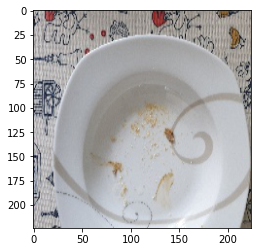

In [10]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

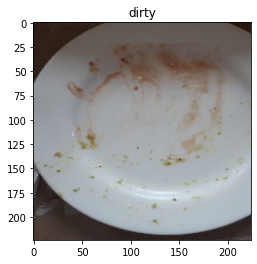

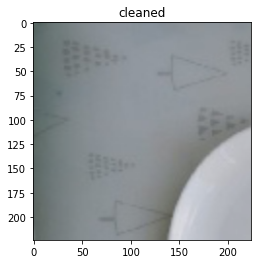

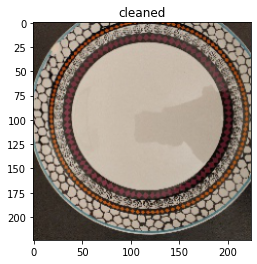

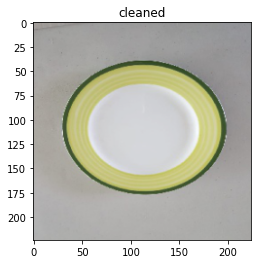

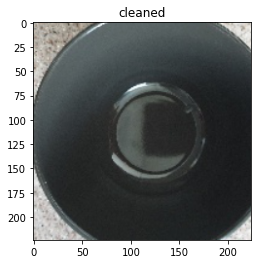

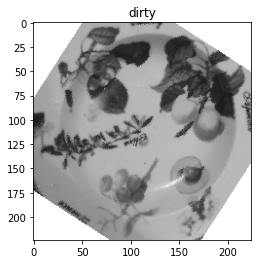

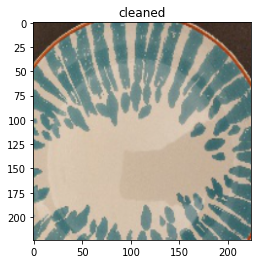

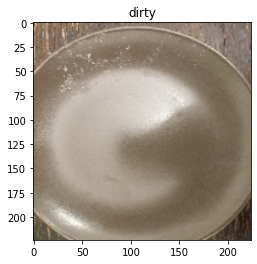

In [11]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

# Model

In [12]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    """
    Обучение модели
    """
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train() 
            else:
                dataloader = val_dataloader
                model.eval() 
            running_loss = 0.
            running_acc = 0.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [13]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

for param in model.avgpool.parameters():
    param.requires_grad = True    

for param in model.layer4.parameters():
    param.requires_grad = True

model.fc = torch.nn.Sequential(
            torch.nn.Linear(model.fc.in_features, 256),
            torch.nn.GELU(),
            torch.nn.Linear(256, 2))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [14]:
train_model(model, loss, optimizer, scheduler, num_epochs=10);

Epoch 0/9:


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 27/27 [00:14<00:00,  1.80it/s]

train Loss: 0.4007 Acc: 0.8380



100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

val Loss: 2.2103 Acc: 0.5000
Epoch 1/9:



100%|██████████| 27/27 [00:15<00:00,  1.75it/s]

train Loss: 0.4413 Acc: 0.8426



100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

val Loss: 1.4963 Acc: 0.5625
Epoch 2/9:



100%|██████████| 27/27 [00:14<00:00,  1.81it/s]

train Loss: 0.1963 Acc: 0.9491



100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

val Loss: 1.1570 Acc: 0.5625
Epoch 3/9:



100%|██████████| 27/27 [00:15<00:00,  1.79it/s]

train Loss: 0.2448 Acc: 0.9444



100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

val Loss: 1.9241 Acc: 0.5625
Epoch 4/9:



100%|██████████| 27/27 [00:14<00:00,  1.80it/s]

train Loss: 0.1593 Acc: 0.9537



100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

val Loss: 1.3846 Acc: 0.5625
Epoch 5/9:



100%|██████████| 27/27 [00:14<00:00,  1.80it/s]

train Loss: 0.0892 Acc: 0.9722



100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

val Loss: 1.5334 Acc: 0.5000
Epoch 6/9:



100%|██████████| 27/27 [00:15<00:00,  1.77it/s]

train Loss: 0.1564 Acc: 0.9537



100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

val Loss: 1.8854 Acc: 0.5000
Epoch 7/9:



100%|██████████| 27/27 [00:15<00:00,  1.79it/s]

train Loss: 0.2910 Acc: 0.9306



100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

val Loss: 1.3825 Acc: 0.5625
Epoch 8/9:



100%|██████████| 27/27 [00:14<00:00,  1.80it/s]

train Loss: 0.1853 Acc: 0.9491



100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

val Loss: 1.1757 Acc: 0.5625
Epoch 9/9:



100%|██████████| 27/27 [00:14<00:00,  1.81it/s]

train Loss: 0.1106 Acc: 0.9537



100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

val Loss: 1.4276 Acc: 0.5625


# Test

In [15]:
test_dir = 'test'
shutil.copytree(os.path.join('plates', 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [16]:
class TestImageDataset(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(TestImageDataset, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        
        return tuple_with_path

In [17]:
test_dataset = TestImageDataset('/kaggle/working/test', val_transforms[0])

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [18]:
def test_predict(model):
    """
    Предсказание на тестовой выборке
    """
    model.eval()
    test_predictions = []
    test_img_paths = []
    for inputs, labels, paths in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs)
        test_predictions.append(
            torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
        test_img_paths.extend(paths)
    
    return test_img_paths, np.concatenate(test_predictions)

In [19]:
test_img_paths = test_predict(model)[0]
test_predictions = test_predict(model)[1]

100%|██████████| 93/93 [00:32<00:00,  2.84it/s]


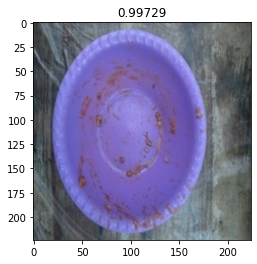

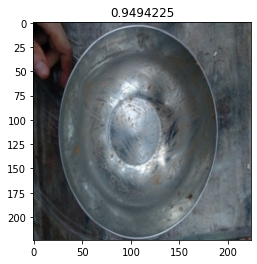

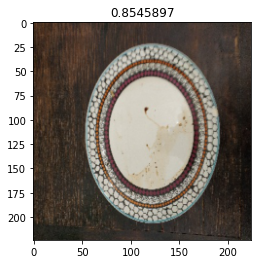

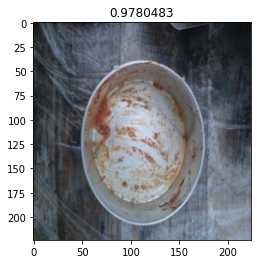

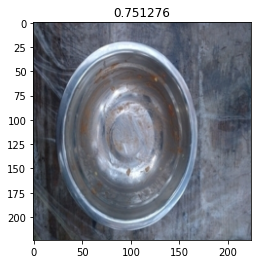

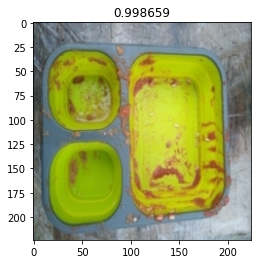

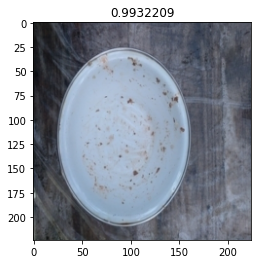

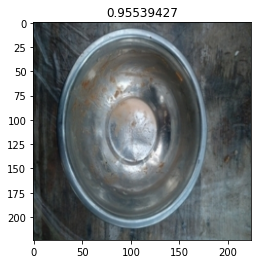

In [20]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [21]:
def get_submission_df(thresh=0.5):
    """
    Получение датафрейма для проверки итогов соревнования
    """
    submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
    submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > thresh else 'cleaned')
    submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
    submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
    submission_df.set_index('id', inplace=True)
    submission_df.to_csv('my_submission.csv')
    
    return submission_df

In [22]:
submission_df = get_submission_df(thresh=0.5)
submission_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
